In [ ]:
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
    ):
        """ Your implementation here """
        self.motion_model = motion_model
        self.static_map = static_map
        self.motion_model = motion_model

        self.v_max = 1.0        # Linear Velocity max
        self.w_min = -2*np.pi
        self.w_max = 2*np.pi
        self.H = 20              # Horizon Length
        self.dt = 0.1           # Time Steps
        self.N = 50            # Number of Rollouts
        self.sig = 0.785        # Deviation for Noise
        self.lmda = 0.1

        self.waypoints = np.array([[-2, -2], [-3, 1], [-1.25, 3.75],
                                   [0.5, 4.65], [3.25, 3], [4, 1], [3,-2]])
        
        # raise NotImplementedError
    
    def get_nearest_goal(self, current_state):
        min_distance = float('inf')  # Initialize with a very large value
        nearest_index = -1           # Default to -1 if no valid waypoint is found
        for i, waypoint in enumerate(self.waypoints):
            dx = waypoint[0] - current_state[0]
            dy = waypoint[1] - current_state[1]
            distance = np.linalg.norm([dx, dy])
            theta_g = np.arctan2(dy, dx)
            dtheta = theta_g - current_state[2]
            dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))
            if abs(dtheta) <= np.radians(90):  
                if distance < min_distance:
                    min_distance = distance
                    nearest_index = i

        return nearest_index
    
    def get_nominal_seq(self, initial_state, goal_pos):
        x, y, theta = initial_state
        nominal_seq = []
        w_min, w_max = -2*np.pi, 2*np.pi

        for _ in range(self.H):
            angle_to_goal = np.arctan2(goal_pos[1] - y, goal_pos[0] - x)
            angle_diff = angle_to_goal - theta
            angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-π, π]
            w = np.clip(angle_diff / self.dt, w_min, w_max)

            distance_to_goal = np.linalg.norm([goal_pos[0] - x, goal_pos[1] - y])
            v = self.v_max if distance_to_goal > self.v_max * self.dt else distance_to_goal / self.dt

            nominal_seq.append([v, w])
            x += v * np.cos(theta) * self.dt
            y += v * np.sin(theta) * self.dt
            theta += w * self.dt
        
        return nominal_seq
    
    # Cost Function
    def cost_function(self, initial_state, goal_pos, seq):
        x, y, theta = initial_state
        distances = []
        ctrl_eff = []

        for v, w in seq:
            x += v * np.cos(theta) * self.dt
            y += v * np.sin(theta) * self.dt
            theta += w * self.dt
            distances.append(np.linalg.norm([x - goal_pos[0], y - goal_pos[1]]))
            ctrl_eff.append(v**2 + w**2)
        
        dist_cost = np.mean(distances)
        ctrl_cost = np.mean(ctrl_eff)
        total_cost = 0.99*dist_cost + 0.01*ctrl_cost
        # print(total_cost)

        return total_cost
    
    def update_control(self, nominal_seq, rollouts, weights):
        du = rollouts - nominal_seq
        seq = np.zeros_like(nominal_seq)
       
        for col in range(len(nominal_seq)):
            seq[col] = np.sum(weights[:, None] * du[:, col], axis=0) / np.sum(weights)

        final_seq = nominal_seq + seq
        final_seq[:, 0] = np.clip(final_seq[:, 0], 0, 1.0)  # Clip v between 0 and 1.0
        final_seq[:, 1] = np.clip(final_seq[:, 1], -2 * np.pi, 2 * np.pi)  # Clip w between -2π and 2π

        return final_seq

    def get_action(self, initial_state: np.array) -> np.array:
        """ Your implementation here """
        goal_pos = self.waypoints[self.get_nearest_goal(initial_state)]
        nominal_seq = self.get_nominal_seq(initial_state, goal_pos)

        rollouts = np.array([[[np.clip(v + np.random.normal(0, self.sig), 0, self.v_max),  
                               np.clip(w + np.random.normal(0, self.sig), -2 * np.pi, 2 * np.pi)] for v, w in nominal_seq] 
                               for _ in range(self.N)])
        scores = np.array([self.cost_function(initial_state, goal_pos, seq) for seq in rollouts])
        weights = np.exp(-1 * scores / self.lmda)
        ctrl_seq = self.update_control(nominal_seq, rollouts, weights)
        action = np.array([0.1, np.radians(5)/self.dt])
        action = np.array(ctrl_seq[0])
        # raise NotImplementedError
        return action

In [9]:
for i in range(14):
    print(f"{0.03*(i+7)}")

0.21
0.24
0.27
0.3
0.32999999999999996
0.36
0.39
0.42
0.44999999999999996
0.48
0.51
0.54
0.57
0.6


In [14]:
import numpy as np
np.pi/3

1.0471975511965976

In [ ]:
x0, y0 = initial_pos
    vx0, vy0 = initial_vel
    xg, yg = goal_pos
    vxg, vyg = goal_vel
    [ux_min, ux_max], [uy_min, uy_max] = u_limits
    T = 10

    current_state = np.array([x0, y0, vx0, vy0])
    states = []

    A = np.array([[1, 0, dt, 0],
                 [0, 1, 0, dt],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
    
    B = np.array([[dt**2/2, 0],
                 [0, dt**2/2],
                 [dt, 0],
                 [0, dt]])
    
    states.append(current_state)
    ax = 2 * (xg - x0) / T**2
    ay = 2 * (yg - y0) / T**2
    ax = np.clip(ax, ux_min, ux_max)
    ay = np.clip(ay, uy_min, uy_max)

    for i in range(T):
        goal_distance = np.linalg.norm(current_state[:2] - np.array([xg, yg]))
        if goal_distance < 0.000000001:
            current_state[2] = 0
            current_state[3] = 0
            states.append(current_state)
            break
        else:
            new_state = np.dot(A, current_state) + np.dot(B, np.array([ax, ay]))
            current_state = new_state
            states.append(current_state)
    # raise NotImplementedError
    states = np.array(states)  
    #print(states)

In [ ]:
x, y = 1.5, -2.0
cx, cy = 0.5, 1.0
a = 5.5 / 2  # Semi-major axis
b = 6.0 / 2  # Semi-minor axis

# Normalize the point coordinates to ellipse frame
norm_x = (x - cx) / a
norm_y = (y - cy) / b

ellipse_value = norm_x**2 + norm_y**2
print(f"{10*(ellipse_value-1)**2}")

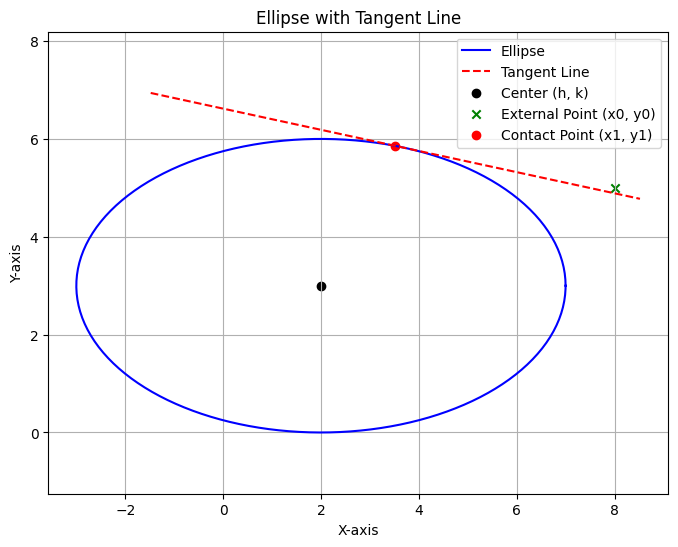

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def ellipse_tangent_contact(h, k, a, b, x0, y0):
    x0_shifted, y0_shifted = x0 - h, y0 - k  # Shift to ellipse-centered coordinates

    def equations(vars):
        x1, y1 = vars
        eq1 = (x1 * x0_shifted) / a**2 + (y1 * y0_shifted) / b**2 - 1  # Tangent condition
        eq2 = (x1**2) / a**2 + (y1**2) / b**2 - 1                      # Ellipse equation
        return [eq1, eq2]

    theta_guess = np.arctan2(y0_shifted * a**2, x0_shifted * b**2)
    x1_guess = a * np.cos(theta_guess)
    y1_guess = b * np.sin(theta_guess)

    x1, y1 = fsolve(equations, (x1_guess, y1_guess))

    return x1 + h, y1 + k

def plot_ellipse_tangent(h, k, a, b, x0, y0):
    # Generate ellipse points
    t = np.linspace(0, 2 * np.pi, 300)
    ellipse_x = h + a * np.cos(t)
    ellipse_y = k + b * np.sin(t)

    # Find tangent contact point
    x1, y1 = ellipse_tangent_contact(h, k, a, b, x0, y0)

    # Compute tangent line equation
    slope = -((x1 / a**2) / (y1 / b**2))  # Derivative of ellipse equation
    intercept = y1 - slope * x1  # y = mx + c

    # Generate tangent line points
    x_tangent = np.linspace(x1 - 5, x1 + 5, 100)
    y_tangent = slope * x_tangent + intercept

    # Plot ellipse
    plt.figure(figsize=(8, 6))
    plt.plot(ellipse_x, ellipse_y, 'b', label="Ellipse")

    # Plot tangent line
    plt.plot(x_tangent, y_tangent, 'r--', label="Tangent Line")

    # Plot points
    plt.scatter(h, k, color='black', marker='o', label="Center (h, k)")
    plt.scatter(x0, y0, color='green', marker='x', label="External Point (x0, y0)")
    plt.scatter(x1, y1, color='red', marker='o', label="Contact Point (x1, y1)")

    # Labels and grid
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.title("Ellipse with Tangent Line")
    plt.legend()
    plt.grid()
    plt.axis("equal")  # Equal aspect ratio

    plt.show()

# Example usage
h, k = 2, 3  # Center of the ellipse
a, b = 5, 3  # Semi-major and semi-minor axes
x0, y0 = 8, 5  # External point

plot_ellipse_tangent(h, k, a, b, x0, y0)


In [ ]:
def optimize_trajectory_with_obstacles(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    obstacles: list,
) -> np.ndarray:

    """ Your implementation here"""
    waypoints = get_waypoints(initial_pos, goal_pos)
    total_points = []
    for point in waypoints:
        total_points.append(point)
    total_points = np.array(total_points)
    trajectory = []
    
    for i in range(len(total_points)):

        # if i != len(total_points) - 1:
        mid_trajectory = optimal_trajectory(
            initial_pos=initial_pos,
            initial_vel=initial_vel,
            goal_pos=total_points[i],
            goal_vel=goal_vel,
            u_limits=u_limits,
            dt=dt,
            goal=True,
        )
        initial_pos = mid_trajectory[-1, 0:2]
        initial_vel = mid_trajectory[-1, 2:4]

        # else:
        #     mid_trajectory = optimal_trajectory(
        #         initial_pos,
        #         initial_vel,
        #         goal_pos,
        #         goal_vel,
        #         u_limits,
        #         dt,
        #         goal=True,
        #     )
        trajectory.append(mid_trajectory)
    return np.vstack(trajectory)


def get_waypoints(initial_pos, goal_pos):
    waypoints = np.array([(1, 6), (2, 6), (2, 7), (3, 7), (3, 8), (3, 9), (3, 10), (4, 10), (5, 10), (6, 10)])
    waypoints = waypoints * 0.5
    return waypoints

def optimal_trajectory(initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    goal: bool = False,
) -> np.ndarray:
    
    T = 20
    x = cp.Variable((4, T + 1))
    u = cp.Variable((2, T))

    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    
    B = np.array([[dt**2/2, 0],
                  [0, dt**2/2],
                  [dt, 0],
                  [0, dt]])
    
    constraints = [x[:, 0] == np.hstack((initial_pos, initial_vel))]

    # Control limits and system dynamics constraints
    for t in range(T):
        constraints += [
            x[:, t + 1] == A @ x[:, t] + B @ u[:, t],
            u[:, t] >= u_limits[:, 0],  
            u[:, t] <= u_limits[:, 1]   
        ]

    # final objective function
    objective = cp.Minimize(
        cp.sum_squares(x[0:2, T] - goal_pos) + 0.1 * cp.sum_squares(u)
    )

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)

    if problem.status != cp.OPTIMAL:
        raise ValueError("Optimization failed!")

    return x.value.T